In [10]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sys
sys.path.insert(0, '/pbabkin/main/mipt/nas-for-moe/code/data')
sys.path.insert(0, '/pbabkin/main/mipt/nas-for-moe/code')
import nas_moe.vae
import nas_moe.dataset
import nas_moe.surrogate
import nas_moe.single_arch
import nas_moe.graph
import nas_moe.utils
import os
import json
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
from pathlib import Path
import torch.nn as nn
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
from nni.nas.hub.pytorch import DARTS as DartsSpace
from torch_geometric.utils import dense_to_sparse
from scipy.stats import pearsonr, spearmanr
import random

SEED = 322
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
folder_path = Path('/pbabkin/main/mipt/nas-for-moe/code/data/CIFAR10_acc/trained_models_archs_1')
# folder_path = Path('/pbabkin/main/mipt/nas-for-moe/code/data/CIFAR10_div/CIFAR10_div/architectures')
# folder_path = Path('./data/CIFAR10_div/CIFAR10_div/architectures')
json_paths = [Path(x) for x in os.listdir(folder_path)]

In [13]:
valid_predictions_list = []
valid_acc_list = []
architecture_list = []
for json_path in json_paths:
    with open(folder_path / json_path, 'r') as file:
        data = json.load(file)

    valid_predictions_list += [data['valid_predictions']]
    valid_acc_list += [data['valid_accuracy']]
    architecture_list.append(data['architecture'])
        
    file_path = Path("data.json")

In [14]:
model_space = DartsSpace(
    width=16,
    num_cells=8,
    dataset='cifar'
)
archGenerator = nas_moe.single_arch.ParamFilteredArchitectureGenerator(model_space, 8, 3, threshold=0.7)

In [15]:
arch_parameters = []
for a in architecture_list:
    arch_parameters.append(archGenerator.count_params(a))

Pearson correlation: 0.4698 (p-value: 4.9914e-56)
Spearman correlation: 0.4743 (p-value: 3.2081e-57)


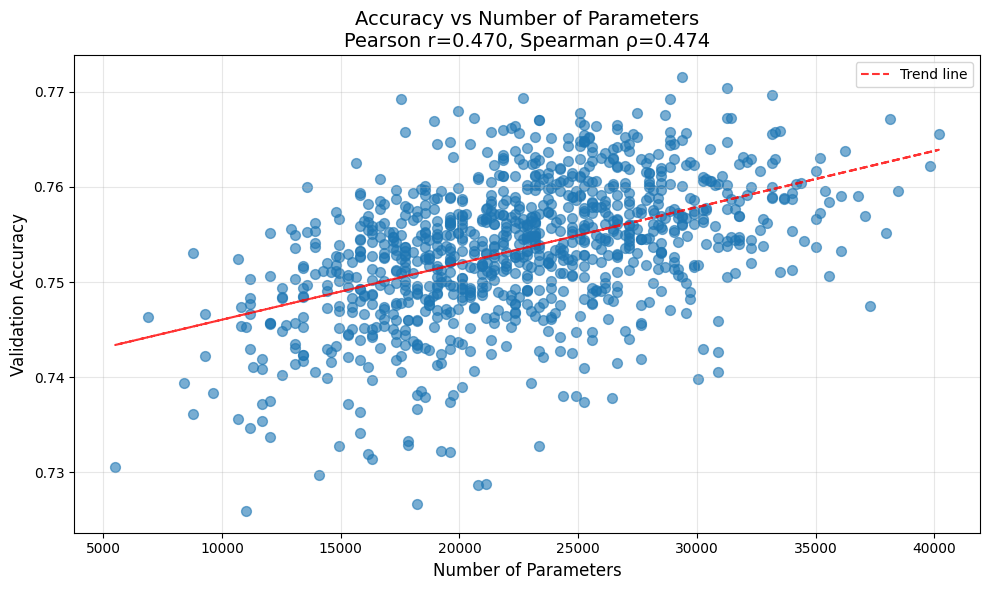


Number of architectures: 1000
Accuracy range: [0.7259, 0.7715]
Parameters range: [5,504, 40,192]


In [18]:
valid_acc = np.array(valid_acc_list)
params = np.array(arch_parameters)

# Вычисляем корреляции
pearson_corr, pearson_pval = pearsonr(params, valid_acc)
spearman_corr, spearman_pval = spearmanr(params, valid_acc)

print(f"Pearson correlation: {pearson_corr:.4f} (p-value: {pearson_pval:.4e})")
print(f"Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_pval:.4e})")

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(params, valid_acc, alpha=0.6, s=50)

z = np.polyfit(params, valid_acc, 1)
p = np.poly1d(z)
plt.plot(params, p(params), "r--", alpha=0.8, label=f'Trend line')

plt.xlabel('Number of Parameters', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title(f'Accuracy vs Number of Parameters\nPearson r={pearson_corr:.3f}, Spearman ρ={spearman_corr:.3f}', 
          fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Дополнительная статистика
print(f"\nNumber of architectures: {len(valid_acc)}")
print(f"Accuracy range: [{valid_acc.min():.4f}, {valid_acc.max():.4f}]")
print(f"Parameters range: [{params.min():,}, {params.max():,}]")
